# Machine learning for muon energy reconstruction in a high-granularity calorimeter
 

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import h5py
import json
import matplotlib.pyplot as plt
import sparse
from pathlib import Path

In [2]:
from metric import compute_improvement

In [3]:
from plotting import *

## Visualization of a single muon in the calorimeter 

The calorimeter is segmented into 50 layers in $z$ and each layer is further segmented in $x$ and $y$ in $32 \times 32$ cells. This results in $51200$ channels in total. The muon enters the simulated calorimeter in the $z$ direction. The colour palette indicates logarithmic energy deposits of the muon. Black corresponds to zero, red to intermediate, and white to the maximum energy. 

In [4]:
hits, true_energy = load_tree("0.root")

In [5]:
hits_sub, true_energy_sub = restrict_energy(hits, true_energy, e_range = [1500, 1800])

plotting...


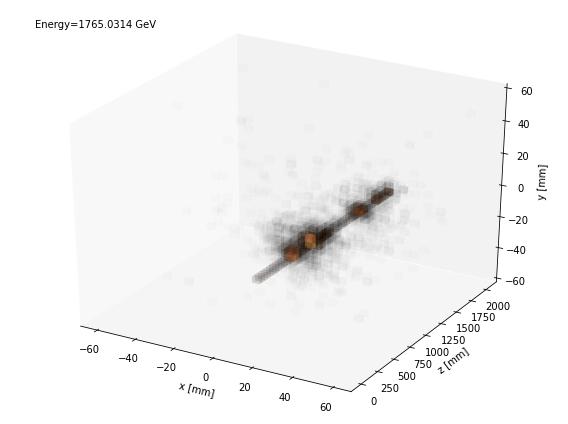

In [6]:
plot_eventdisplay(1, hits_sub, true_energy_sub, usegrid=False, save=False)

## Load high level features

In [7]:
PATH = Path("/home/centos/mount_point/data/cmu_challenge/")

In [9]:
def get_hl(file_name:str, path:Path=PATH):
    
    file = h5py.File(path/file_name, "r+")
    cont_feats = json.loads(file['meta_data/cont_feats'][()])
    hl_inputs = file['fold_0/inputs'][()]  # muon x feature numpy array
    targets = file['fold_0/targets'][()]  # muon x 1
    file.close()
    return hl_inputs, targets

In [10]:
X_train, y_train = get_hl('muon_calo_train.hdf5')
X_val, y_val = get_hl('muon_calo_val.hdf5')

## Regression with a Boosted Decision Tree with high level features

In [11]:
# create an xgboost regression model
bdt = xgb.XGBRegressor(objective='reg:squarederror')

In [12]:
bdt.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

[0]	validation_0-rmse:3431.62109	validation_1-rmse:3442.57617
[1]	validation_0-rmse:2652.03784	validation_1-rmse:2664.36084
[2]	validation_0-rmse:2166.18408	validation_1-rmse:2180.58911
[3]	validation_0-rmse:1877.05432	validation_1-rmse:1893.61340
[4]	validation_0-rmse:1713.70581	validation_1-rmse:1732.47595
[5]	validation_0-rmse:1624.76172	validation_1-rmse:1646.39722
[6]	validation_0-rmse:1576.15173	validation_1-rmse:1600.81580
[7]	validation_0-rmse:1548.77478	validation_1-rmse:1576.76050
[8]	validation_0-rmse:1533.12524	validation_1-rmse:1562.65649
[9]	validation_0-rmse:1523.63294	validation_1-rmse:1555.32581
[10]	validation_0-rmse:1517.64624	validation_1-rmse:1551.34082
[11]	validation_0-rmse:1513.13721	validation_1-rmse:1548.86340
[12]	validation_0-rmse:1508.64661	validation_1-rmse:1547.30335
[13]	validation_0-rmse:1504.48950	validation_1-rmse:1545.88709
[14]	validation_0-rmse:1501.33716	validation_1-rmse:1545.75000
[15]	validation_0-rmse:1499.26660	validation_1-rmse:1545.07861
[1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=36, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [13]:
y_pred = bdt.predict(X_val) # Predictions

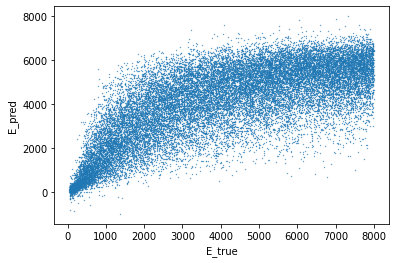

In [14]:
plt.scatter(y_val, y_pred, s=0.1)
plt.xlabel("E_true")
plt.ylabel("E_pred")
plt.show()

### Compute improvement

 Since our setup only includes a calorimeter, we assume that the resolution of a tracking measurement, performed independently by an upstream or downstream detector, scales linearly with energy, and equals 20% resolution at 1 TeV. We evaluate the resolution of both the regressor measurement and the simulated tracker measurement, along with the resolution of their weighted average. Resolution here is the fractional root median squared-error computed in bins of true energy according to:
            $$
                \text{Resolution} = \frac{\sqrt{\left(\tilde{E_p}-\tilde{E_t}\right)^2+\Delta_{68}\left[E_p\right]^2}}{\tilde{E_t}},
            $$
            where $\tilde{E_p}$ and $\tilde{E_t}$ are the median predicted and true energies in a given bin of true energy, and $\Delta_{68}\left[E_p\right]$ is the difference between the 16th and 84th percentiles of the predicted energy in that bin (the central 68th percentile width). When computing the resolution on the testing data (which are generated at fixed points of true energy), $\tilde{E_t}$ is instead the true energy at a given point.

In [15]:
df = pd.DataFrame({'pred': y_pred, 'target': y_val})

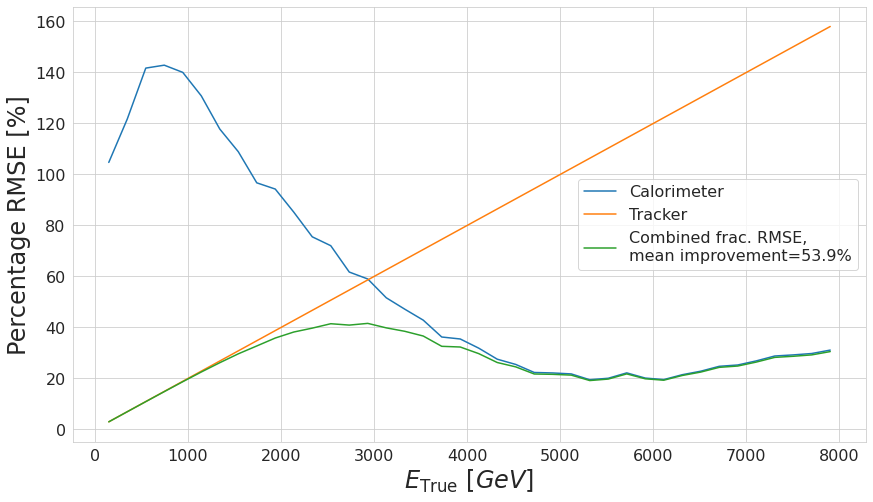

0.5389641848248535

In [16]:
compute_improvement(df)

## Create a submission

To create a submission for the challenge, predict the unlabelled 'muon_calo_test.hdf5' sample and save it to csv.

In [17]:
X_test, _ = get_hl('muon_calo_test.hdf5')

In [18]:
def create_submission(model, name="submission"):
    y_pred = model.predict(X_test)
    df = pd.DataFrame({'pred': y_pred})
    df.to_csv(name + ".csv")

In [19]:
create_submission(bdt)